# Adjacency Matrix visualization

In [1]:
import torch
import pandas as pd
from dataset import Dataset
import networkx as nx
from torch_geometric_temporal.nn import MTGNN
from config import CONFIG
from pathlib import Path
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
from pyproj import Proj

c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data & Weights

In [2]:
dataset = Dataset(CONFIG.model_config.seq_length - 1, countries=CONFIG.countries)

In [3]:
country_df = pd.read_csv('../country.csv', delimiter='\t')
pos_dict = country_df.set_index('name')[['latitude ', 'longitude ']].to_dict()

In [4]:
PATH = Path("../") / "artifacts" / "model.pt"
model_config = CONFIG.model_config
model_config.num_nodes = len(dataset.dataframe.columns)
model = MTGNN(**model_config.dict())
model.load_state_dict(torch.load(PATH))
model = model.eval()

## Graph

In [5]:
node_labels = dataset.dataframe.columns

In [6]:
A_tilde = model._graph_constructor(model._idx, FE=None)
graph = nx.from_numpy_array(A_tilde.cpu().detach().numpy())

In [7]:
# Attributes
edge_weights = nx.get_edge_attributes(graph, 'weight')
labels = {x: c for x, c in  zip(graph.nodes, node_labels)}
p = Proj('EPSG:4326')
cmap = plt.get_cmap('viridis')
colors = [cmap(x) for x in edge_weights.values()]
pos = {n: p(pos_dict['longitude '][c], pos_dict['latitude '][c]) for n, c in zip(graph.nodes, node_labels)}

c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\networkx\drawing\nx_pylab.py:304: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


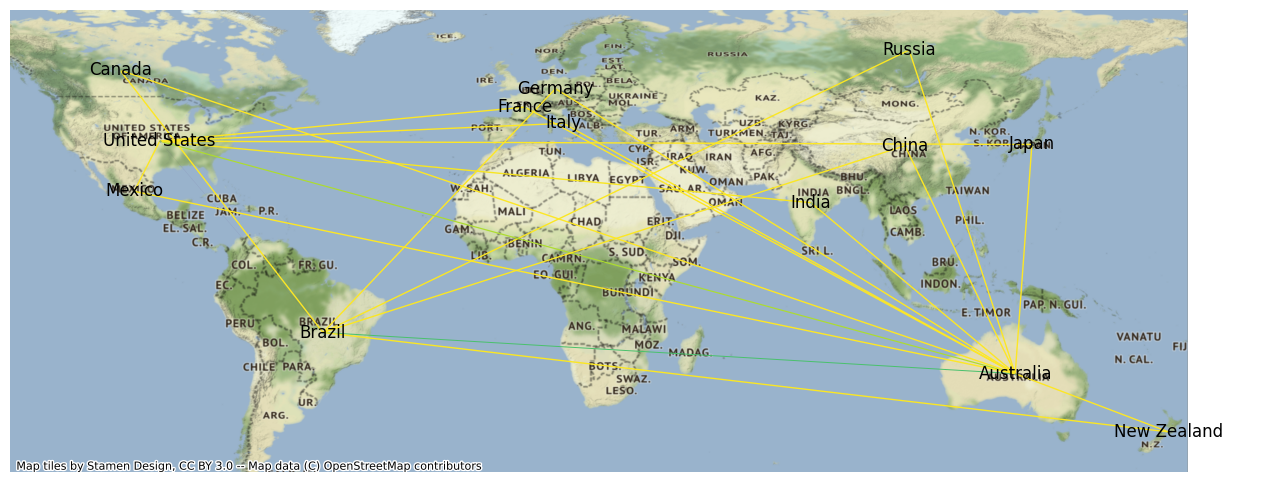

In [8]:
fig, ax = plt.subplots(figsize=(20,6))
nx.draw(graph, pos, labels=labels,  node_size=0.1, with_labels=True, width=np.array(list(edge_weights.values())), ax=ax, edge_color=colors, connectionstyle="arc3,rad=0.1")
cx.add_basemap(ax, crs="EPSG:4326")